In [37]:
%load_ext autoreload
%autoreload 2
%pylab nbagg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/home/xcite/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['scatter', 'det']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [38]:
import sys
import os
import tigre
from scipy.signal import fftconvolve

sys.path.insert(0,'../xpecgen')

import xpecgen as xg
from scipy.optimize import minimize, curve_fit

In [44]:
dose = 0

phan_map_hard =  ['air','water','G4_BONE_COMPACT_ICRU','G4_BONE_CORTICAL_ICRP',
             'Spongiosa_Bone_ICRP','C4_Vertebra_ICRP','D6_Vertebra_ICRP','G4_B-100_BONE']

phan_map_g4 = ['air','water','G4_LUNG_ICRP',"G4_BONE_COMPACT_ICRU","G4_BONE_CORTICAL_ICRP","G4_ADIPOSE_TISSUE_ICRP","G4_BRAIN_ICRP","G4_B-100_BONE"] 


phan_map_water = ['air','water','water','water',
             'water','water','water','water','water']

spectrum_files = ['W_spectrum_6', 'Al_spectrum_6', 'Al_spectrum_6', 'C_spectrum_25', 'W_spectrum_6', 'W_spectrum_25']

dets = ['CWO-784-micrometer','CuGOS-784-micrometer']

phan_maps = [phan_map_g4,phan_map_hard]#,phan_map_soft]

res = []

original_energies_keV = np.array([30, 40, 50 ,60, 70, 80 ,90 ,100 ,300 ,500 ,700, 900, 1000 ,2000 ,4000 ,6000])


angles = np.linspace(0,2*pi,2)

geo = 'catphan_low_contrast_512'

phantom = xg.Catphan_515()

phantom.geomet.DSD = 1520
phantom.geomet.dDetector = np.array([0.784, 0.784])
phantom.geomet.sDetector = phantom.geomet.dDetector * phantom.geomet.nDetector  
phantom.geomet.accuracy = 0.5

scats = []

for phan_map in phan_maps[:1]:
    for spectrum_file in spectrum_files[:2]:
        for det in dets[1:]:
            s = xg.Spectrum()
            s.load(spectrum_file)

            kernel = xg.Kernel(s, det)

            energy_deposition_file = os.path.join(
                xg.data_path, "Detectors", det, 'EnergyDeposition.npy')
            energies = s.x
            fluence = s.y
            deposition_efficiency_file = energy_deposition_file

            noise = xg.update_fluence(spectrum_file,dose)

            geo = phantom.geomet            
            phan = phantom.phantom
            phantom_mapping = phan_map
            nphoton = noise
            dose = 0
            
            # Don't want to look for zeros we generally avoid air
            useful_phantom = phan != 0
            
            # These are what I used in the Monte Carlo
            original_energies_keV = np.array([30, 40, 50 ,60, 70, 80 ,90 ,100 ,300 ,500 ,700, 900, 1000 ,2000 ,4000 ,6000])
            # Loading the file from the monte carlo
            deposition = np.load(deposition_efficiency_file,allow_pickle=True)
            # This is a scaling factor that I found to work to convert energy deposition to photon probability eta
            deposition_summed = deposition[0]/(original_energies_keV/1000)/1000000
            # The index of the different materials
            masks = np.zeros([len(phantom_mapping)-1,useful_phantom.shape[0],useful_phantom.shape[1],useful_phantom.shape[2]])
            mapping_functions = []
            # Get the mapping functions for the different tissues to reconstruct the phantom by energy
            for ii in range(1,len(phantom_mapping)):       
                mapping_functions.append(xg.get_mu(phantom_mapping[ii]))
                masks[ii-1] = phan == ii
            phantom2 = phan.copy().astype(np.float32) # Tigre only works with float32
            phantom3 = phan.copy().astype(np.float32)

            # --- Ray tracing step ---
            mu_en_water = np.array([0.1557  , 0.06947 , 0.04223 , 0.0319  , 0.027678, 0.02597 ,
               0.025434, 0.02546 , 0.03192 , 0.03299 , 0.032501, 0.031562,
               0.03103 , 0.02608 , 0.02066 , 0.01806 ])
            mu_water = np.array([0.3756  , 0.2683  , 0.2269  , 0.2059  , 0.19289 , 0.1837  ,
               0.176564, 0.1707  , 0.1186  , 0.09687 , 0.083614, 0.074411,
               0.07072 , 0.04942 , 0.03403 , 0.0277  ])
            mu_woutcoherent_water = np.array([3.286E-01  , 2.395E-01   , 2.076E-01 , 1.920E-01  , 1.824E-01 , 1.755E-01  ,
               1.700E-01, 1.654E-01 , 1.180E-01 , 9.665E-02 , 8.351E-02, 7.434E-02,
               7.066E-02 , 4.940E-02 , 0.03402 , 0.0277  ])

            proj = []
            proj2 = []
#             doses = []

            for jj, energy in enumerate(original_energies_keV):
                for ii in range(0,len(phantom_mapping)-1):
                    phantom2[masks[ii].astype(bool)] = mu_woutcoherent_water[jj]
                    phantom3[masks[ii].astype(bool)] = mapping_functions[ii](energy)
                proj.append(np.squeeze(tigre.Ax(phantom2,geo,angles)))
                proj2.append(np.squeeze(tigre.Ax(phantom3,geo,angles)))
#                 # Calculate a dose contribution by dividing by 10 since tigre has projections that are a little odd
#                 doses.append((energy)*(1-np.exp(-(proj[-1][0]*mu_en_water[jj]/mu_water[jj]*.997)/10)))
            
            # --- Factoring in the fluence and the energy deposition ---
            # Binning to get the fluence per energy
            large_energies = np.linspace(0,6000,3001)
            fluence_large = np.interp(large_energies,np.array(energies), fluence)
            fluence_small = np.zeros(len(original_energies_keV))
            # Still binning
            for ii, val in enumerate(large_energies*1000):   
                index = np.argmin(np.abs(original_energies_keV-val))
                fluence_small[index] += fluence_large[ii]       
            # Normalize
            fluence_small /= np.sum(fluence_small)
            fluence_norm = fluence/np.sum(fluence)
            weights_small = fluence_small #*deposition_summed
            # Need to make sure that the attenuations aren't janky for recon
            weights_small /= np.sum(weights_small)
            # This is the line to uncomment to run the working code for dose_comparison.ipynb

            # --- Noise and Scatter Calculation ---
            # Now I interpolate deposition and get the average photons reaching the detector
            deposition_long = np.interp(energies,original_energies_keV/1000,deposition_summed)
            nphotons_at_energy = fluence_norm*deposition_long
            nphotons_av = np.sum(nphotons_at_energy)
            # These are the MC scatter kernels primary and total
            
            data_path = xg.data_path #'./data/'
            
            primary = np.load(os.path.join(data_path,'scatter','primary.npy'))
            noise = np.load(os.path.join(data_path,'scatter','total.npy'))
            scatter = np.load(os.path.join(data_path,'scatter','scatter.npy'))
            e_dist = np.load(os.path.join(data_path,'scatter','e_dist.npy'))
            flood = np.load(os.path.join(data_path,'scatter','total_flood.npy'))
            scatter_coh = np.load(os.path.join(data_path,'scatter','coherent_scatter.npy'))
            
            scatter_edep = scatter @ e_dist/np.sum(e_dist,0)
            
#             projs = np.load(os.path.join(xg.data_path,'scatter','fc_water_w_coherent.npy'))

            
#             primary = np.load(os.path.join(xg.data_path,'noise','primary_projections.npy')) #TODO: save these as something smaller
#             noise = np.load(os.path.join(xg.data_path,'noise','noise_projections.npy'))
            analytical = np.array(proj)[:,0,:,:] #np.load('water_proj.npy')
            analytical2 = np.array(proj2)[:,0,:,:]
            # np.save('primary_projections',primary)
            # sum the noise kernel with the weights
            
            flood_summed = np.mean(flood,1)
            
                        
            dist = np.linspace(-256*0.0784 - 0.0392,256*0.0784 - 0.0392, 512)

            factor = ((phantom.geomet.DSD/10)/(np.sqrt(dist**2 + (phantom.geomet.DSD/10)**2)))**3
            
            flood_summed2 = factor*660 #np.mean(flood[250:260])

            projs = (np.exp(-np.mean(analytical/10,1))*(flood_summed2)).T
            projs_coh = (np.exp(-np.mean(analytical2/10,1))*(flood_summed2)).T

            
            mc_noise = noise @ weights_small
            mc_prime = primary @ weights_small
            fc_prime = projs @ weights_small
            fc_prime_2 = projs_coh @ weights_small
            mc_scatter2 = scatter @ weights_small
            coh_scatter = scatter_coh @ weights_small
            mc_scatter_e = scatter_edep @ weights_small
            
            def func(x, a, b):
                return ((-(152/(np.sqrt(x**2 + 152**2)))**a)*b)

            scatter_smooth = np.zeros(scatter.shape)

            for jj in range(len(original_energies_keV)):

                    popt, popc = curve_fit(func,dist,scatter[:,jj],[10,scatter[256,jj]])
                    scatter_smooth[:,jj] = func(dist, *popt)

            
#             scatter_weighted = scatter_array.T @ weights_small
            
#             mc_scatter2 = np.sum(scatter_weighted,1)
            mc_scatter = scatter_smooth @ weights_small

            
            scats.append(fc_prime_2 + 2.15*(mc_scatter + coh_scatter))
            #scatter is not all the same

0.0
0.0


<IPython.core.display.Javascript object>


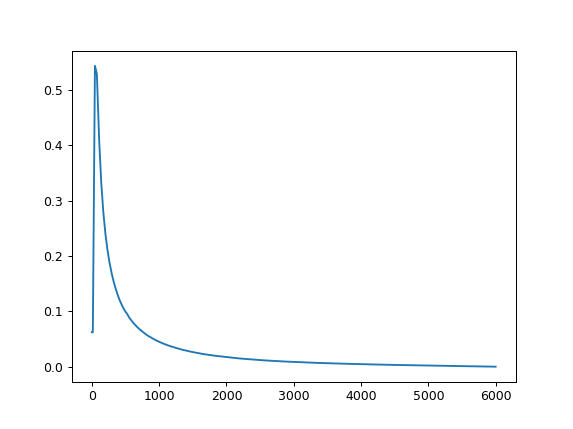

In [45]:
figure();plot(large_energies,100*fluence_large/sum(fluence_large))#;bar(original_energies_keV/1000,fluence_small/10)

In [5]:
(fc_prime_2 + 2.15*(mc_scatter + coh_scatter))[256]

160.7507221935126

In [6]:
# np.save('coherent_scatter',projs -projs_coh)

In [7]:
real_spec = np.load('data/w_spec_profile.npy')
real_spec_water = np.load('data/w_spec_profile_water.npy')
real_spec_water_2 = np.load('w_spec6_profile_water.npy')
# real_spec_water_3 = np.load('w_spec6_profile_water_2.npy')
real_spec_CT = np.load('/home/xcite/scintillators/Catphan_dose/batch_submission_W/analysis/Readout_0000.phsp.npy')

<IPython.core.display.Javascript object>


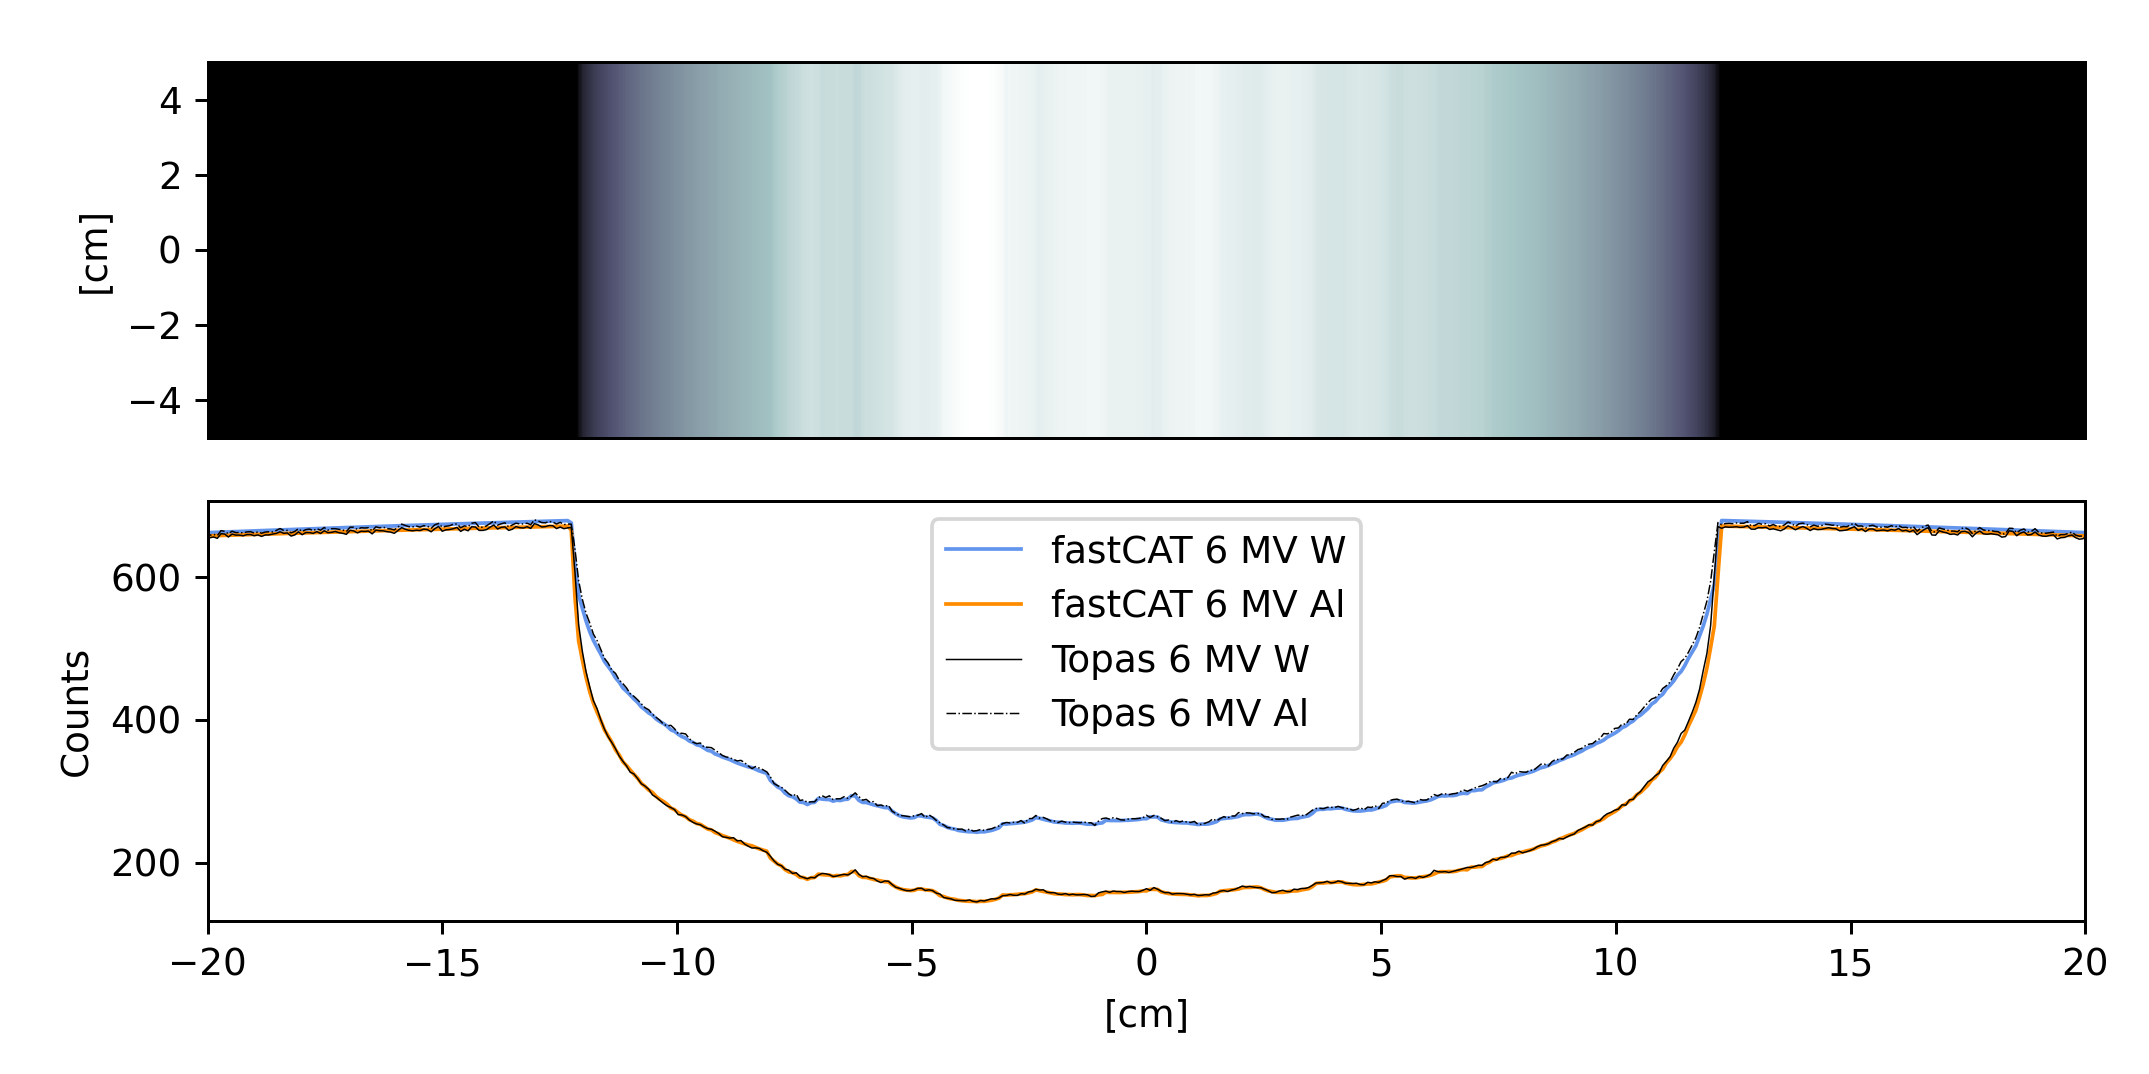

In [35]:
# plt.figure()
# plt.plot(-np.log(mc_noise/flood_summed2))

plt.figure(dpi=300,figsize=[8,4])
plt.subplot(211)
plt.imshow(-np.log(np.tile(fc_prime_2,[128,1])/flood_summed2),cmap='bone',extent=[-25,25,-5,5])
plt.ylabel('[cm]')
plt.xticks([])
plt.subplot(212)
# plt.plot(2*mc_noise)

# The primary projection don't include any scatter should add the coherent and the incoherent scatter
plt.plot(dist,scats[0],linewidth = 1.0,color = 'cornflowerblue')
plt.plot(dist,scats[1],linewidth = 1.0,color = 'darkorange')

# plt.plot(fc_prime_2 + 3*mc_scatter - 2*coh_scatter,'r',linewidth= 0.7)
# plt.plot(fc_prime_2)
# plt.plot(flood_summed2)
plt.plot(dist,real_spec,'k-',linewidth = 0.4)
plt.plot(dist,np.mean(real_spec_CT,0),'k-.',linewidth = 0.4,markersize=0.4)
plt.xlim([-20,20])
# plt.plot(dist,real_spec_water_2,'k--',linewidth = 0.7)
# plt.plot(real_spec_water_3*2,'k--',linewidth = 0.7)

plt.legend(['fastCAT 6 MV W', 'fastCAT 6 MV Al','Topas 6 MV W', 'Topas 6 MV Al'])
plt.xlabel('[cm]')
plt.ylabel('Counts')
plt.tight_layout()
# plt.plot(real_spec_water,'k',linewidth= 0.7)
# plt.plot(fc_prime_2 + 2*mc_scatter_e,'r')
# plt.plot(2*mc_noise,'g')
# plt.plot(fc_prime_2,'.')

In [36]:
plt.savefig('/home/xcite/fastcat_paper/figures/one_slice_comparison.pdf')

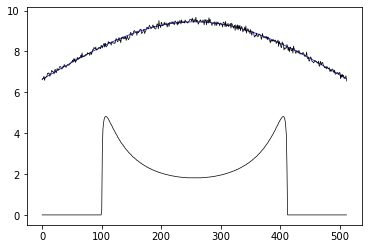

In [209]:
plt.figure()
plt.plot(mc_scatter,'b',linewidth= 0.7)
plt.plot(mc_scatter2,'k',linewidth= 0.7)
plt.plot(coh_scatter,'k',linewidth= 0.7)

In [119]:
curve_fits = np.load('curve_fits.npy')

<IPython.core.display.Javascript object>


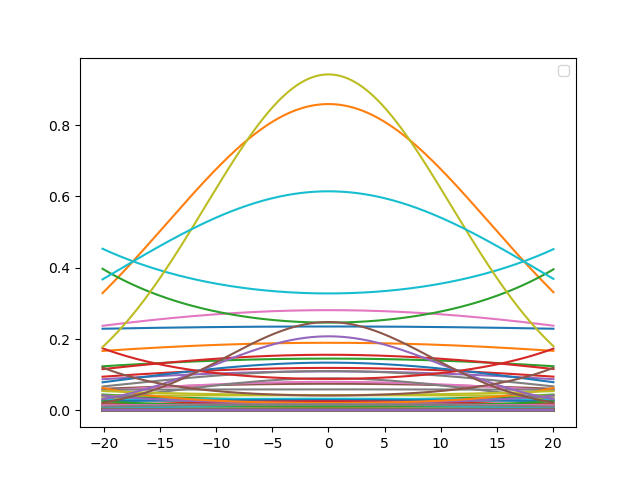

No handles with labels found to put in legend.


In [127]:
dist = np.linspace(-256*0.0784 - 0.0392,256*0.0784 - 0.0392, 512)

def func(x, a, b):

    return ((-(152/(np.sqrt(x**2 + 152**2)))**a)*b)

plt.figure()

scatter_array2 = np.zeros([curve_fits.shape[0],curve_fits.shape[1],dist.shape[0]])
sc = []

for jj in range(len(original_energies_keV)):
    for ii in range(len(original_energies_keV)):
    
        plt.plot(dist,func(dist, *curve_fits[ii,jj,:])*weights_small[jj]/128)
        
        scatter_array2[ii,jj] = func(dist, *curve_fits[ii,jj,:]*weights_small[jj])/128
        
        sc.append(func(dist, *curve_fits[ii,jj,:]*weights_small[jj])/128)
    
plt.legend()

<IPython.core.display.Javascript object>


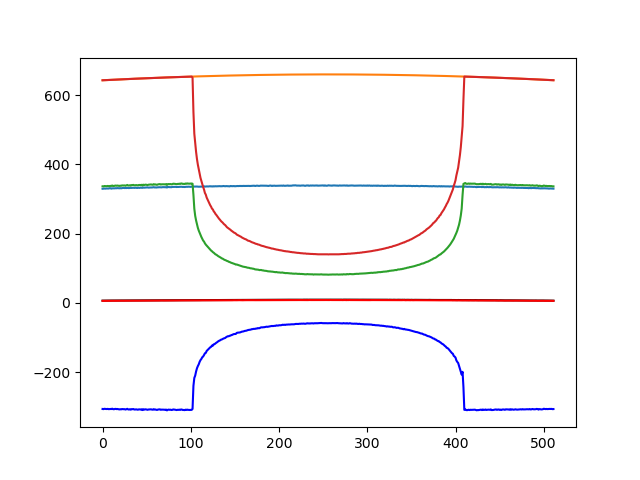

In [268]:
plt.figure()
plt.plot(flood_summed)
plt.plot(flood_summed2)
plt.plot(mc_noise)
plt.plot(fc_prime)
plt.plot(mc_scatter,'k')
plt.plot(fc_scatter,'b')
plt.plot(mc_scatter_e,'r')

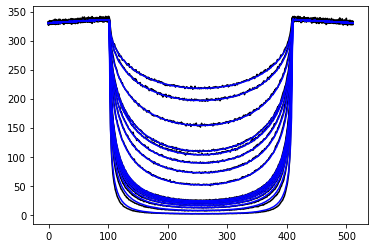

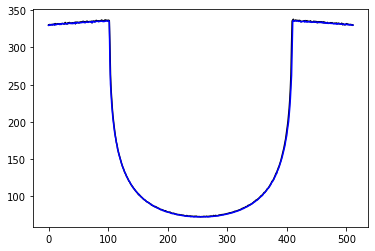

In [100]:
plt.figure()
# for ii in range(16):
projs = (np.exp(-np.mean(analytical/10,1))*(flood_summed/2)).T
# #     plt.plot(noise[:,ii],'k')
plt.plot(primary,color='k')
plt.plot(projs,'b')

plt.figure()
plt.plot(primary@fluence_small,'k')
plt.plot(projs@fluence_small,'b')

<IPython.core.display.Javascript object>


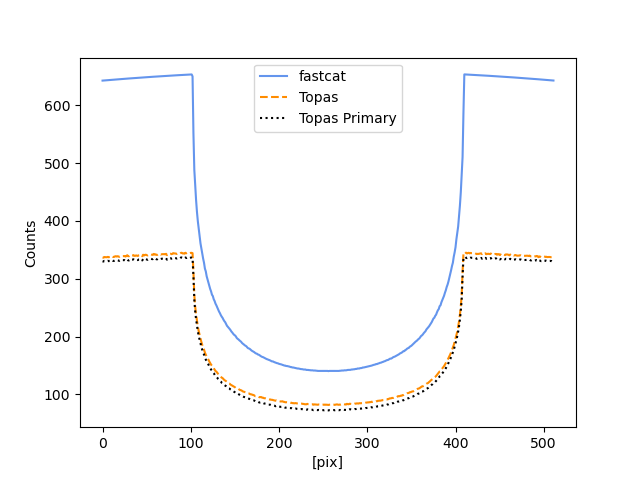

Text(0, 0.5, 'Counts')

In [272]:
plt.figure()
# plt.plot(scatter)
# plt.plot(raw_proj_noise)
plt.plot(fc_prime,color='cornflowerblue')
# plt.plot(mean_analytical)
plt.plot(mc_noise,'--',color='darkorange')
plt.plot(mc_prime,'k:')
plt.legend(['fastcat','Topas','Topas Primary'])
plt.xlabel('[pix]')
plt.ylabel('Counts')
# plt.savefig('fastcat_topas_raw_projection')

In [7]:
primary = np.load('primary.npy')
noise = np.load('total.npy')
scatter = np.load('scatter.npy')
e_dist = np.load('e_dist.npy')
flood = np.load('total_flood.npy')

<IPython.core.display.Javascript object>


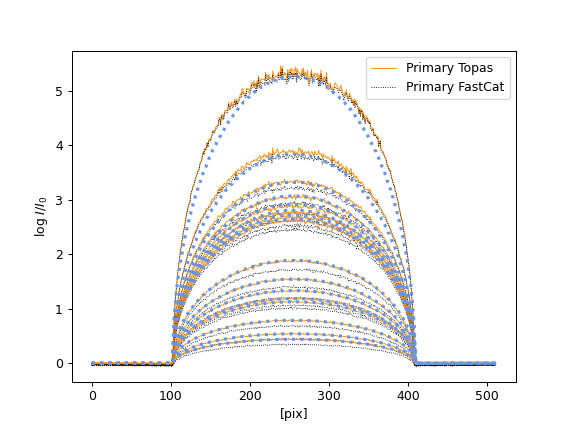

In [8]:
plt.figure()

for ii in range(16):

    plt.plot(-np.log(primary[:,ii]/(flood[:,ii]/2)),color='darkorange',linewidth=0.7)
    plt.plot(-np.log(noise[:,ii]/(flood[:,ii]/2)),':',color='k',linewidth=0.7)
    plt.plot(np.mean(analytical[ii,:,:]/10,0),':',color='cornflowerblue',linewidth=2.5)
    plt.xlabel('[pix]')
    plt.ylabel('log $I/I_0$')

plt.legend(['Primary Topas','Primary FastCat'])
# plt.savefig('Primary_Comparison')

<IPython.core.display.Javascript object>


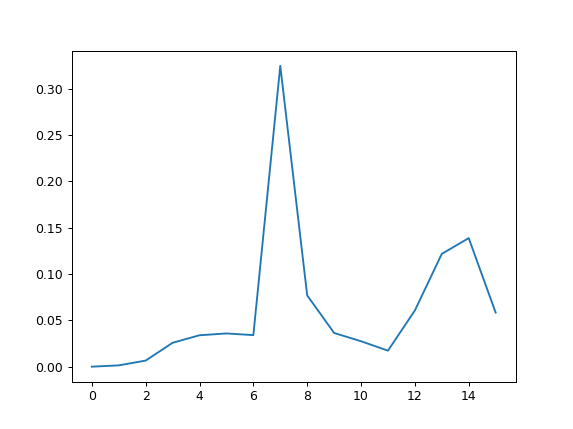

In [10]:

plt.figure()
plt.plot(weights_small)

In [150]:
dx = 3.5

In [154]:
3.286E-01 * 16

5.2576

In [152]:
xg.get_mu('water')(40 + dx) * 16

4.030693145663892

In [153]:
xg.get_mu('water')(50 + dx) * 16

3.5018889609755863

In [58]:
analytical.shape

(16, 64, 512)

In [101]:
3.756E-01 * 16 * 0.997

5.9915712

In [93]:
3.538E-01 * (150-16) * 0.01205 

0.57128086

In [94]:
2.485E-01 * (150-16) * 0.01205

0.40125295

/home/xcite/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


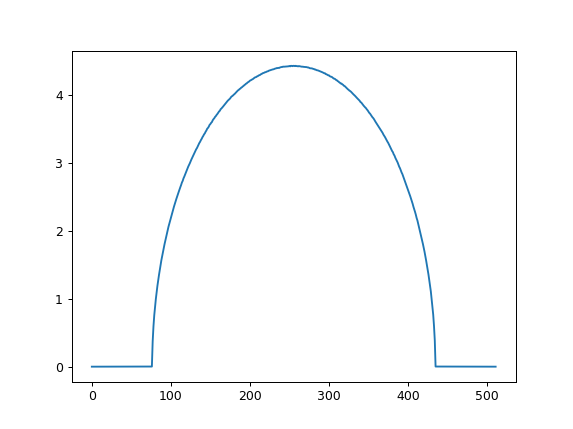

In [60]:
plt.figure()
plt.plot()

In [74]:
xg.get_mu('air')(6000)

3.0390100000000023e-05

In [51]:
4*2.522E-02

0.10088

In [52]:
16 * 2.770E-02  # 4.44 = 

0.4432

In [44]:
mapping_functions[1](6000)

0.027700000000000002

In [42]:
phan_map

['air', 'water', 'water', 'water', 'water', 'water', 'water', 'water']

<IPython.core.display.Javascript object>


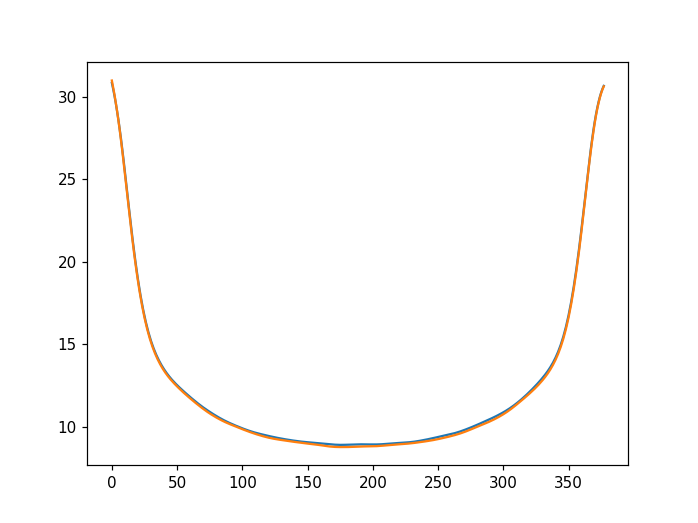

In [105]:
from scipy import signal

b, a = signal.butter(2, 0.05)

pad = 68

x = signal.filtfilt(b, a, raw_noise[pad:-pad+2])
y = signal.filtfilt(b, a, raw_prime[pad:-pad+2])

plt.figure()
plt.plot(x)
plt.plot(y)

<IPython.core.display.Javascript object>


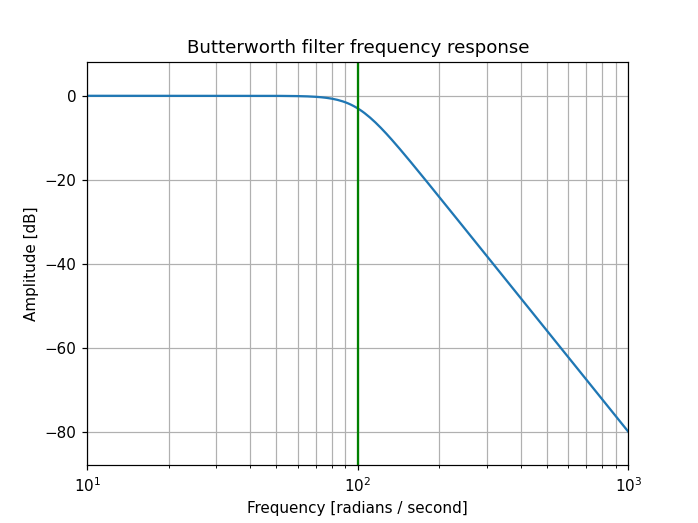

In [84]:
plt.semilogx(w, 20 * np.log10(abs(h)))

plt.title('Butterworth filter frequency response')

plt.xlabel('Frequency [radians / second]')

plt.ylabel('Amplitude [dB]')

plt.margins(0, 0.1)

plt.grid(which='both', axis='both')

plt.axvline(100, color='green') # cutoff frequency

plt.show()

In [30]:
phantom.geomet

AttributeError: 'numpy.ndarray' object has no attribute 'geomet'

In [ ]:
primary = np.load(os.path.join(data_path,'noise','primary_projections.npy')) #TODO: save these as something smaller
noise = np.load(os.path.join(data_path,'noise','noise_projections.npy'))
# np.save('primary_projections',primary)
# sum the noise kernel with the weights
noise_summed = noise.T @ weights_small
# weight the primary
primary_summed = primary.T @ weights_small
# analytical
analytical_summed = np.array(proj).T @ weights_small
# Get a 2d sum
raw_prime = np.mean(np.sum(primary_summed,0),0)
raw_noise = np.mean(np.sum(noise_summed,0),0)
mean_analytical = np.mean(analytical_summed[:,:,0],1)

def get_rmse(x):
    return np.sum(np.abs(np.exp(-mean_analytical/x[0])*x[1] - raw_prime))
def get_rmse_noise(x):
    return np.sum(np.abs(np.exp(-mean_analytical/x[0])*x[1] - raw_noise))

scale = minimize(get_rmse,[10,32])
scale_noise = minimize(get_rmse_noise,[10,32])

raw_proj = np.exp(-mean_analytical/scale.x[0])*scale.x[1]
# get the noise
raw_proj = np.exp(-mean_analytical/scale.x[0])*scale.x[1]
raw_proj_noise = np.exp(-mean_analytical/scale_noise.x[0])*scale_noise.x[1]
scatter = raw_proj_noise - raw_proj